## Домашнее задание

### Задание 1
Попробуйте сделать функцию-враппер (функцию-обертку) вокруг DESeq2, которая будет работать из-под Python и выполнять дифференциальную экспрессию по матрице каунтов, а также по датасету с описанием образцов, которые будут даваться на вход функции. Продумайте, как лучше реализовать хранение аутпута.

### Решение

#### Установка пакетов и импорт данных

Установим необходимые библиотеки

In [ ]:
!pip3 install scanpy[leiden] anndata2ri scikit-misc scvi-tools opentsne harmonypy

# Необходимо, чтобы конкретно прогрузился matplotlib
import os
os.kill(os.getpid(), 9)

Обновим версию gdown

In [ ]:
!pip install --upgrade --no-cache-dir gdown

Импортируем необходимые модули в python

In [ ]:
!pip install rpy2==3.5.1

In [24]:
import rpy2

rpy2.__version__

'3.5.1'

In [1]:
import scanpy as sc

import anndata2ri
anndata2ri.activate()

%reload_ext rpy2.ipython

import rpy2.robjects as ro
ro.numpy2ri.activate()

from rpy2.robjects import pandas2ri, Formula
from rpy2.robjects.packages import importr

sc.set_figure_params(dpi=150)
sc.settings.verbosity = 3

In [ ]:
!apt-get install libgmp3-dev libcairo2-dev libharfbuzz-dev libfribidi-dev libudunits2-dev
!gdown --id 1W0TuuQospxcasOX5cQdhT_Xd-k7-QAck
!tar xf library.tar.gz
!cp -r /content/usr/local/lib/R /usr/local/lib/ >> None
!rm -r usr library.tar.gz

In [ ]:
%R .libPaths("usr/local/lib/R/site-library/")

!Rscript -e 'install.packages("dplyr")'
!Rscript -e 'install.packages("ggplot2")'
!Rscript -e 'install.packages("tidyr")'
!Rscript -e 'install.packages("stringr")'
!Rscript -e 'install.packages("statmod")'
!Rscript -e 'install.packages("MASS")'
!Rscript -e 'BiocManager::install("EnhancedVolcano")'
!Rscript -e 'BiocManager::install("DESeq2")'
!Rscript -e 'BiocManager::install("apeglm")'
!Rscript -e 'install.packages("repr")'
!Rscript -e 'BiocManager::install("glmGamPoi")'

In [2]:
%%R

suppressPackageStartupMessages({
  library(edgeR)
  library(stringr)
  library(dplyr)
  library(tidyr)
  library(ggplot2)
  library(MASS)
  library(glue)
  library(EnhancedVolcano)
  library(DESeq2)
  library(apeglm)
  library(repr)
  library(glmGamPoi)
})

Скачаем single cell данные

In [7]:
!gdown "1jW548g6ERFS0t7NywgyjRs6VaE5QwXbg&confirm=t"

Downloading...
From: https://drive.google.com/uc?id=1jW548g6ERFS0t7NywgyjRs6VaE5QwXbg&confirm=t
To: /content/PBMC_Satija.h5ad
100% 243M/243M [00:02<00:00, 85.8MB/s]


Прочитаем `.h5ad` файл

In [8]:
adata_raw = sc.read_h5ad("PBMC_Satija.h5ad")
adata_raw.layers["counts"] = adata_raw.X.copy()

Выберем из изначального датасета только 20 клеток. Это необходимо, так как при анализе дифф. экспрессии всего датасета переполняется ОЗУ, и колаб автоматически сбрасывает все локальные переменные, освобождая оперативную память.

In [9]:
adata = adata_raw.copy()
adata = adata[:20, :]

Пусть тестируемыми группами будут колонки: батчи (образцы тканей от различных доноров) и типу клеток, к которому принадлежит та или иная клетка из scRNA-seq.

In [29]:
adata.obs['donor'].value_counts()

P2    9
P1    8
P3    3
Name: donor, dtype: int64

In [30]:
adata.obs['celltype.l1'].value_counts()

CD8 T      8
CD4 T      7
NK         2
B          1
Mono       1
other T    1
Name: celltype.l1, dtype: int64

In [ ]:
adata.obs.head()

,orig.ident,lane,donor,time,celltype.l1,celltype.l2,celltype.l3,Phase
L1_AAACCCACATCAGTCA,P3_3,L1,P3,3,CD8 T,CD8 TEM,CD8 TEM_1,G1
L1_AAACCCATCCACACCT,P3_3,L1,P3,3,CD8 T,CD8 Naive,CD8 Naive,S
L1_AAACCCATCTGCGGAC,P1_0,L1,P1,0,CD4 T,CD4 TCM,CD4 TCM_1,S
L1_AAACCCATCTTAAGGC,P2_3,L1,P2,3,CD4 T,CD4 CTL,CD4 CTL,S
L1_AAACGAAAGATAACAC,P2_3,L1,P2,3,B,B naive,B naive kappa,S


#### DESeq2 с single cell данными

Напишем функцию-оболочку DESeq2, которая будет проводить анализ дифф. экспрессии c AnnData объектом. 

Вместо указания в аргументе функциии описания образцов добавил аргумент `formula`, который позволяет указывать на вход функции, какой будет дизайн у эксперимента.

In [ ]:
def deseq2(adata, formula):
    '''
    Wrapper function of DESeq2 R package, 
    that compute differential expression 
    with single cell data.
    ----------
    adata : AnnData
        Annotated data matrix.
    formula : str
        Formula for DESeq2 model

    Returns
    ----------
    AnnData object.
    '''

    # Import DESeq2 library from R to Python
    deseq2 = importr("DESeq2")

    # Create DESeqDataSet from AnnData object
    dds = deseq2.DESeqDataSetFromMatrix(countData=adata.X.T, 
                                        colData=adata.obs,
                                        design=Formula(formula))
    
    # Evaluate differential expression by DESeq2 model
    dds = deseq2.DESeq(dds)

    # Write DESeq2 results into AnnData object    
    adata.uns["deseq2"] = dds

    return adata

Сохранять DESeq2 результаты будем в виде двух файлов:
1. `.rds` файл — в нем будет находиться `DESeqDataSet` объект с результатами DESeq2
2. `.h5ad` файл — в нем будет сохранен изначальный `AnnData` объект.

Выбрал такую логику сохранения, так как это позволяет работать с результатами дифф. экспрессии прямо в Python.

In [8]:
def write_deseq2(adata, output):
    '''
    This saves AnnData Object with DESeqDataSet object into two file:
    .rds file (DESeqDataSet object) and
    .h5ad file (AnnData object). 
    ----------
    adata : AnnData
        Annotated data matrix.
    output : str
        Save file name.
    '''

    # import saveRDS R library into Python
    saveRDS = ro.r['saveRDS']

    # Save R DESeqDataSet object with DESeq2 results into .rds file
    saveRDS(adata.uns["deseq2"], f'{output}.rds')

    del adata.uns["deseq2"]

    # Save Python object AnnData object without DESeq2 results into .h5ad file
    adata.write(f'{output}.h5ad')

In [28]:
formula = '~ donor'

In [14]:
adata_with_deseq2 = deseq2(adata, formula)






   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.



-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)



/usr/local/lib/python3.8/dist-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


In [15]:
write_deseq2(adata_with_deseq2, 'deseq2_output')

Напишем функцию для чтения результатов DESeq2.

In [20]:
def read_deseq2(read_name):
    '''
    This reads DESeqDataSet object and AnnData object
    and returns AnnData Object with DESeq2 results.
    ----------
    adata : AnnData
        Annotated data matrix.
    read_name : str
        Read file name.

    Returns
    ----------
    AnnData object.
    '''

    # Read .h5ad file with AnnData object
    adata = sc.read_h5ad(f'{read_name}.h5ad')

    # Import readRDS library
    readRDS = ro.r['readRDS']

    # Read .rds file and add it into AnnData object
    adata.uns["deseq2"] = readRDS(f'{read_name}.rds')

    return adata

In [40]:
adata_with_deseq2 = read_deseq2('deseq2_output')

In [41]:
dds = adata_with_deseq2.uns['deseq2']

In [47]:
%%R -i dds

head(results(dds))

log2 fold change (MLE): donor P3 vs P1 
Wald test p-value: donor P3 vs P1 
DataFrame with 6 rows and 6 columns
   baseMean log2FoldChange     lfcSE      stat    pvalue      padj
  <numeric>      <numeric> <numeric> <numeric> <numeric> <numeric>
1 0.0000000             NA        NA        NA        NA        NA
2 0.0000000             NA        NA        NA        NA        NA
3 0.0000000             NA        NA        NA        NA        NA
4 0.0374795       0.428725   4.58106 0.0935863  0.925438   0.99385
5 0.2184640       1.029846   4.02870 0.2556275  0.798238   0.99385
6 0.0000000             NA        NA        NA        NA        NA


### Задание 2

Приспособьте эту функцию для scanpy так, чтобы она могла определять дифференциально экспрессированные гены для кластеров, используя их псевдобалки по отдельным образцам. В каком случае имеет смысл использовать эту функцию?

### Решение

Заново загрузим датасет в Python

In [4]:
adata_raw = sc.read_h5ad("PBMC_Satija.h5ad")
adata_raw.layers["counts"] = adata_raw.X.copy()
adata_harmony = adata_raw.copy()

Трансфорируем и кластеризуем исходные данные

In [5]:
sc.pp.normalize_total(adata_harmony)
sc.pp.log1p(adata_harmony)

sc.pp.highly_variable_genes(
    adata_harmony,
    n_top_genes=3000,
    flavor="seurat_v3",
    layer="counts",
    batch_key="donor"
)

sc.pp.scale(adata_harmony)
sc.tl.pca(adata_harmony, n_comps=15)
sc.external.pp.harmony_integrate(adata_harmony, key="donor", max_iter_harmony=20)

sc.pp.neighbors(
    adata_harmony,
    use_rep="X_pca_harmony",
    n_pcs=15
)

sc.tl.leiden(adata_harmony)
sc.tl.umap(adata_harmony)

normalizing counts per cell
    finished (0:00:00)
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=15
    finished (0:00:04)


2023-01-11 05:59:28,784 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...
2023-01-11 05:59:38,526 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2023-01-11 05:59:38,724 - harmonypy - INFO - Iteration 1 of 20
INFO:harmonypy:Iteration 1 of 20
2023-01-11 05:59:47,452 - harmonypy - INFO - Iteration 2 of 20
INFO:harmonypy:Iteration 2 of 20
2023-01-11 05:59:56,173 - harmonypy - INFO - Iteration 3 of 20
INFO:harmonypy:Iteration 3 of 20
2023-01-11 06:00:01,763 - harmonypy - INFO - Iteration 4 of 20
INFO:harmonypy:Iteration 4 of 20
2023-01-11 06:00:14,146 - harmonypy - INFO - Iteration 5 of 20
INFO:harmonypy:Iteration 5 of 20
2023-01-11 06:00:23,448 - harmonypy - INFO - Iteration 6 of 20
INFO:harmonypy:Iteration 6 of 20
2023-01-11 06:00:33,035 - harmonypy - INFO - Iteration 7 of 20
INFO:harmonypy:Iteration 7 of 20
2023-01-11 06:00:35,948 - 

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:43)
running Leiden clustering
    finished: found 18 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:03)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:25)


In [50]:
adata_harmony

AnnData object with n_obs × n_vars = 17159 × 20729
    obs: 'orig.ident', 'lane', 'donor', 'time', 'celltype.l1', 'celltype.l2', 'celltype.l3', 'Phase', 'leiden'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'leiden', 'umap'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

In [51]:
adata_harmony.obs

,orig.ident,lane,donor,time,celltype.l1,celltype.l2,celltype.l3,Phase,leiden
L1_AAACCCACATCAGTCA,P3_3,L1,P3,3,CD8 T,CD8 TEM,CD8 TEM_1,G1,6
L1_AAACCCATCCACACCT,P3_3,L1,P3,3,CD8 T,CD8 Naive,CD8 Naive,S,1
L1_AAACCCATCTGCGGAC,P1_0,L1,P1,0,CD4 T,CD4 TCM,CD4 TCM_1,S,2
L1_AAACCCATCTTAAGGC,P2_3,L1,P2,3,CD4 T,CD4 CTL,CD4 CTL,S,6
L1_AAACGAAAGATAACAC,P2_3,L1,P2,3,B,B naive,B naive kappa,S,10
...,...,...,...,...,...,...,...,...,...
L5_TTTGTTGGTACGATCT,P2_3,L5,P2,3,NK,NK,NK_2,G1,4
L5_TTTGTTGGTGGTCTGC,P1_0,L5,P1,0,Mono,CD14 Mono,CD14 Mono,G1,3
L5_TTTGTTGTCAACACCA,P2_3,L5,P2,3,Mono,CD14 Mono,CD14 Mono,G1,3
L5_TTTGTTGTCATGCATG,P2_3,L5,P2,3,CD8 T,CD8 Naive,CD8 Naive,G1,1


Посмотрим, как выглядят кластеры наши данных

/usr/local/lib/python3.8/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


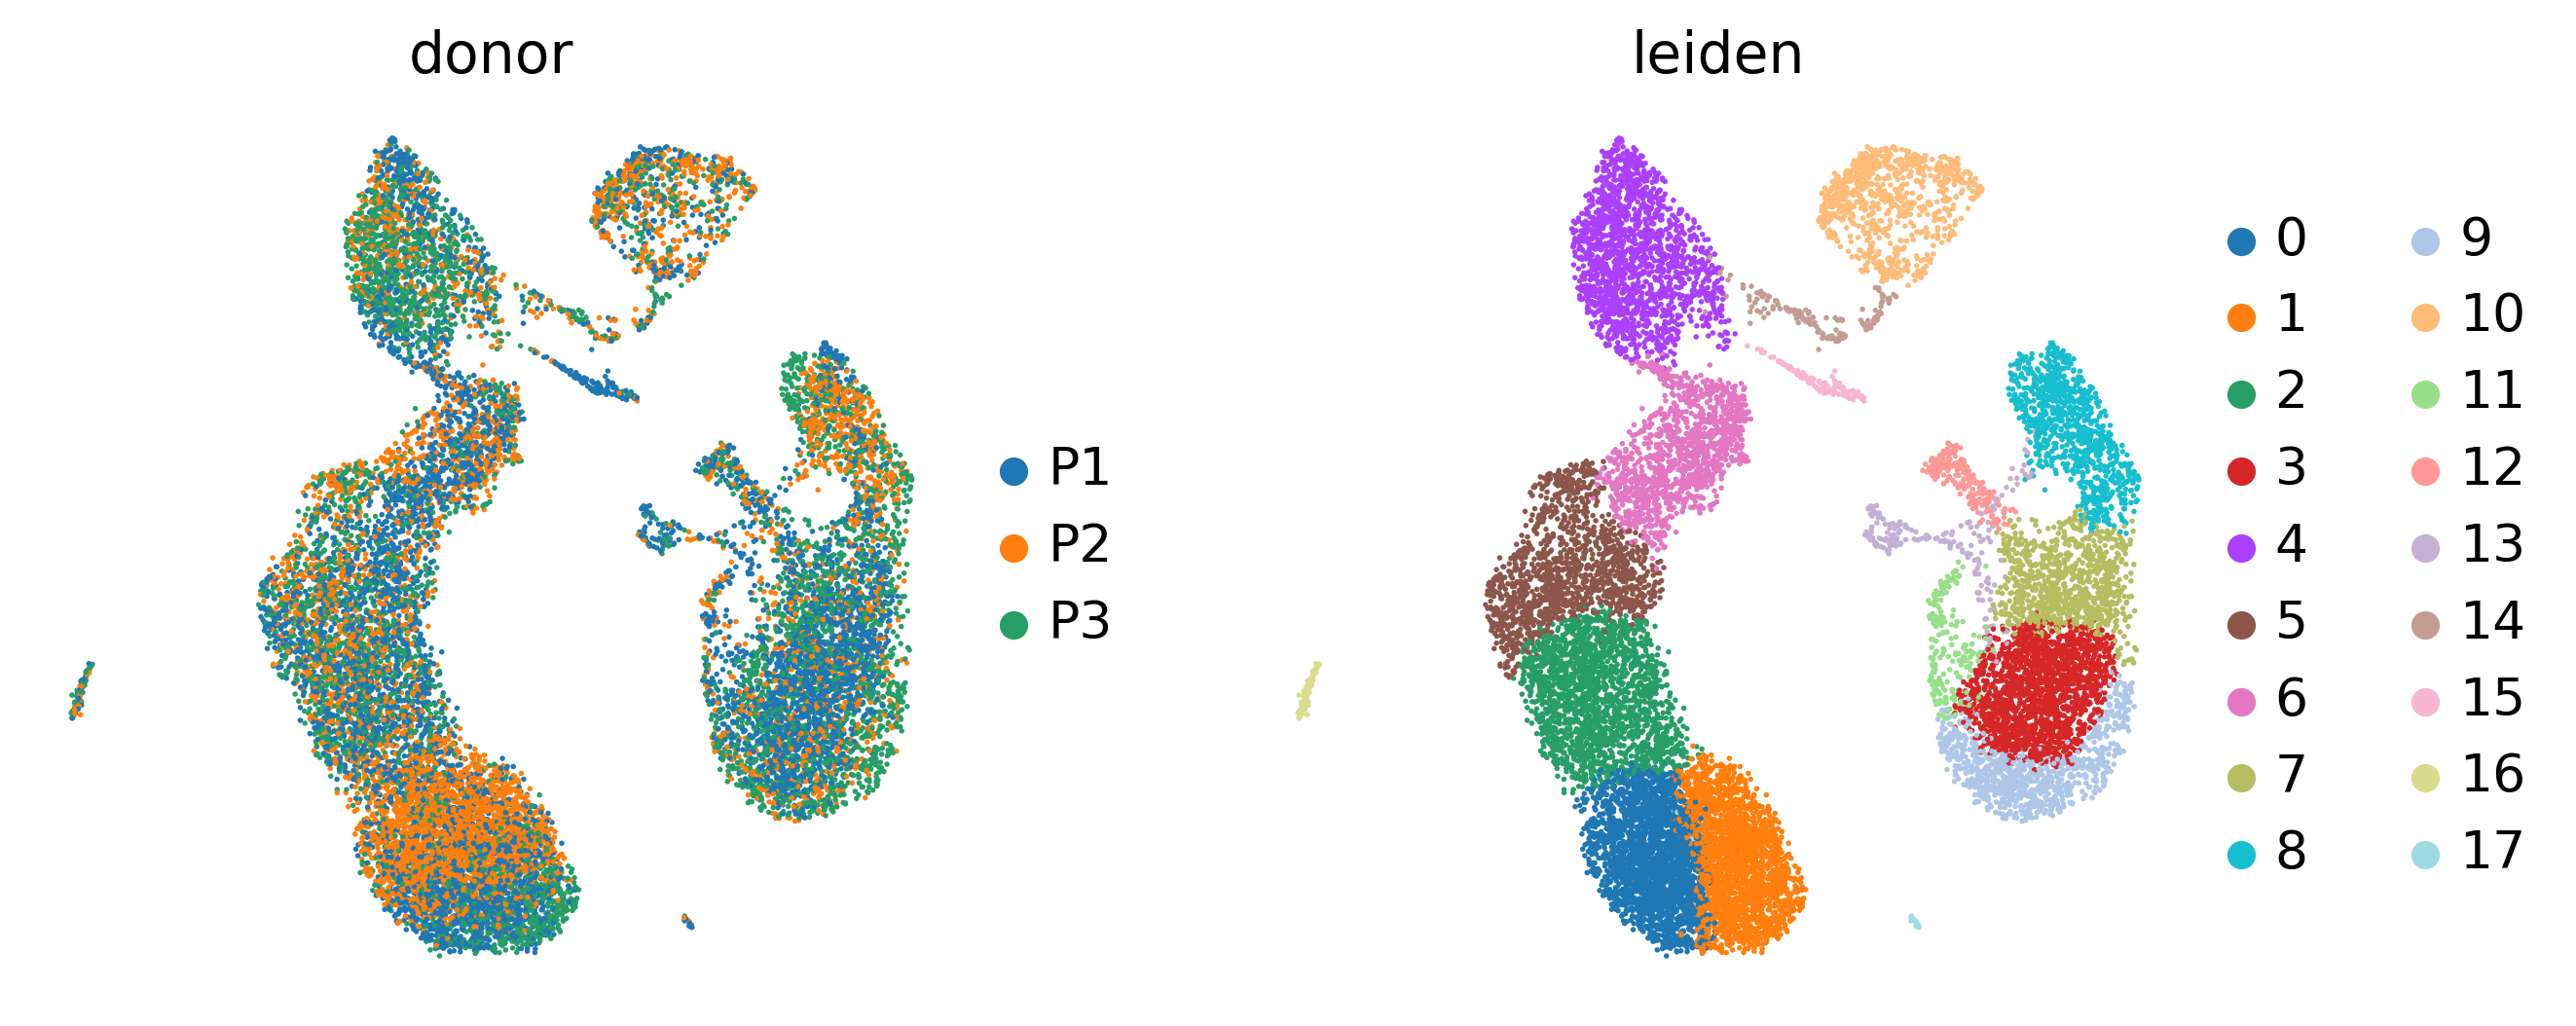

In [19]:
sc.pl.umap(adata_harmony, color=["donor", "leiden"], frameon=False)

In [19]:
def deseq2_clusters(adata, 
                    formula, 
                    clusters_column='leiden', 
                    output='deseq2_clusters'
                    ):
    '''
    Wrapper function of DESeq2 R package, 
    that compute differential expression 
    with clusterized single cell data.
    ----------
    adata : AnnData
        Annotated data matrix.
    formula : str
        Formula for DESeq2 model
    clusters_column : str
        Clusters column name.
    output : str
        Save file name.

    Returns
    ----------
    AnnData object.
    '''

    # Create list of cluster indexes
    clusters = adata.obs[clusters_column].value_counts().index.astype(str)
    
    # Intialized dictionary for saving 
    # DESEq2 results for every cluster
    adata.uns["deseq2"] = dict()

    # Evaluate differential expressions for every cluster
    for cluster in clusters:

        # Select AnnData only for one cluster
        cluster_adata = adata[adata.obs[clusters_column] == cluster]

        # Run DESeq2 for current cluster
        adata_with_dds = deseq2(cluster_adata, formula)

        # Extract DESeq2 results
        dds = adata_with_dds.uns["deseq2"]

        # Save DESeq2 results into dictionary
        adata.uns["deseq2"][cluster] = dds

    return adata

Данную функцию мы можем использовать, если у нас стоит задача анализа дифференциальной экспресси внутри каждого кластера. Например, когда мы хотим изучить изменение экспрессии по батчам внутри группы (кластера) Б-клеток у разных пациентов (батчей).